## A Hierarchical Bayesian Framework for Stellar Obliquity Distribution Inference

**Jiayin Dong**<sup>1</sup> and **Dan Foreman-Mackey**<sup>1</sup>

<sup>1</sup>CCA, Flatiron Institute

February 2023

Jupyter Notebook demonstration for Dong & Foreman-Mackey 2023 to be submitted to the AAS Journals

---

In this notebook, we present a few cases to apply the hierarchical Bayesian model (HBM) described in Dong & Foreman-Mackey 2023 to infer the stellar obliquity $\psi$ distribution of a sample.

Cases:
1. Infer the $\psi$ distribution from $\lambda$ only
2. Infer the $\psi$ distribution from $\lambda$ and $i_\star$
3. Infer the $\psi$ distribution from $\lambda$, $R_\star$, $P_{\rm rot}$, and $v\sin{i_\star}$

You will soon find that, with each dataset, the underlying stellar obliquity distribution can be correctly inferred.

In [1]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import aesara.tensor as at
import aesara

from matplotlib import rc
rc('font', **{'family':'sans-serif'})
rc('text', usetex=True)

In [2]:
print('numpy', np.__version__)
print('pandas', pd.__version__)
print('pymc', pm.__version__)
print('arviz', az.__version__)
print('aesara', aesara.__version__)

numpy 1.23.4
pandas 1.5.1
pymc 4.1.7
arviz 0.13.0
aesara 2.8.2


In [3]:
np.random.seed(123)

Let's first generate some data for this demonstration. 
Assume that we have 200 planetary systems. Among them, 
- 70% of the systems are well aligned with stellar obliquities $\psi$ less than 30$^\circ$
- 30% of the systems are misaligned with stellar obliquities $\psi$ isotropically distributed 

In $\cos{\psi}$ space, this corresponds to

<IPython.core.display.Javascript object>


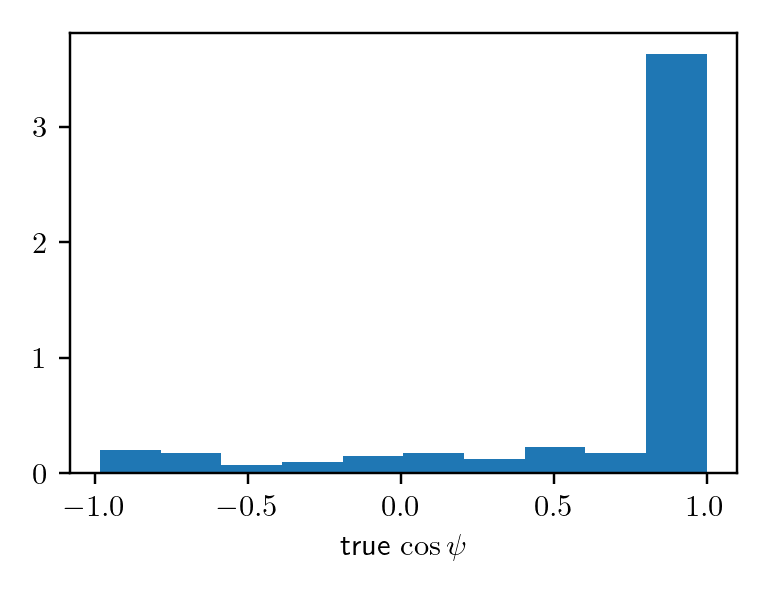

In [4]:
nsample = 200

pop_a = np.random.uniform(np.cos(30*np.pi/180), 1, int(nsample*0.7))
pop_m = np.random.uniform(-1, 1, int(nsample*0.3))
true_cosψ = np.append(pop_a, pop_m)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_cosψ, density=True, bins=10)
plt.xlabel(r'true $\cos{\psi}$')
plt.tight_layout()
plt.show()

Assume the azimuthal angle between the stellar spin axis and orbital axis, $\theta$, is uniformly distributed between $[-\pi/2, \pi/2]$.

<IPython.core.display.Javascript object>


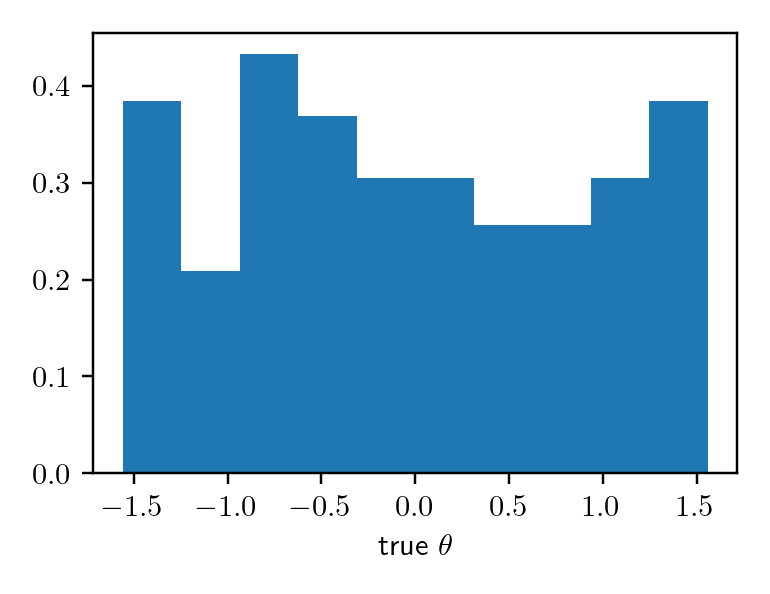

In [5]:
true_θ = np.random.uniform(-np.pi/2, np.pi/2, nsample)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_θ, density=True, bins=10)
plt.xlabel(r'true $\theta$')
plt.tight_layout()
plt.show()

From {$\psi$, $\theta$}, we could now calculate the corresponding sky-projected stellar obliquities $\lambda$ and stellar inclinations $i_\star$. Here we simply assume the orbital inclination is $90^\circ$.

<IPython.core.display.Javascript object>


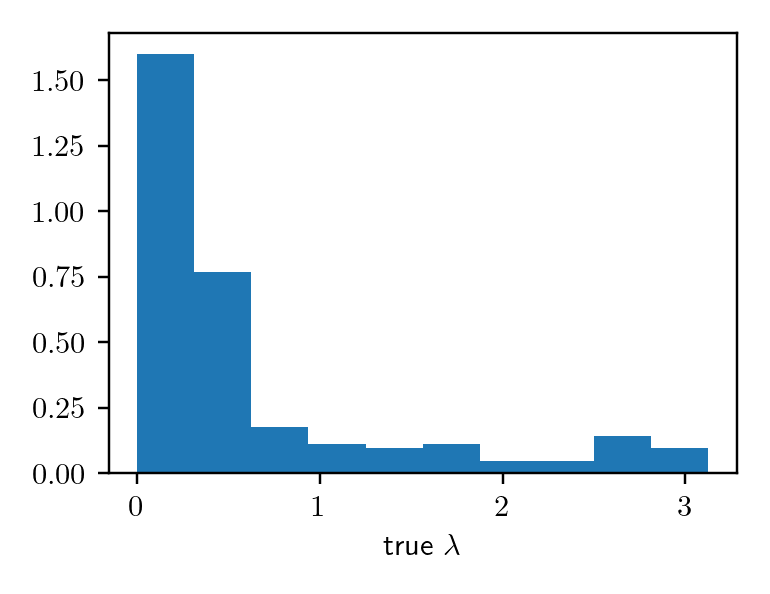

<IPython.core.display.Javascript object>


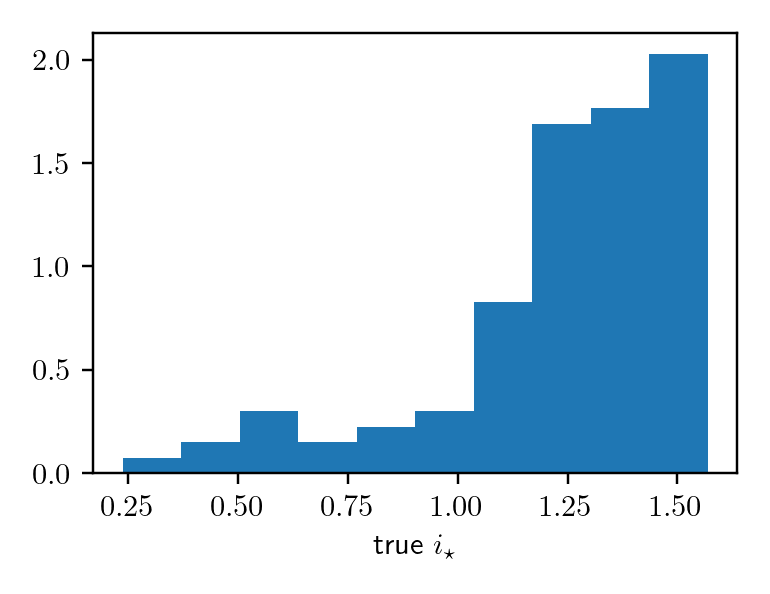

In [6]:
true_lam = np.arccos(true_cosψ/np.sqrt(1-(1-true_cosψ**2)*np.cos(true_θ)**2))
true_istar = np.arccos(np.sqrt(1-true_cosψ**2)*np.cos(true_θ))

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_lam, density=True, bins=10)
plt.xlabel(r'true $\lambda$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_istar, density=True, bins=10)
plt.xlabel(r'true $i_\star$')
plt.tight_layout()
plt.show()

We now add some Gaussian noise to simulate observed lambda and stellar inclination values. We assume $\sigma_{i_\star} = 10^\circ$ and $\sigma_\lambda = 8^\circ$.

<IPython.core.display.Javascript object>


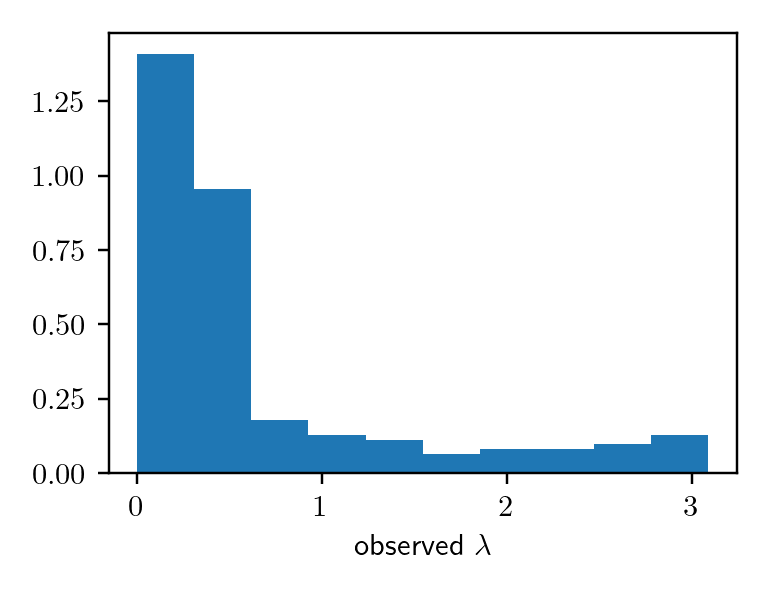

<IPython.core.display.Javascript object>


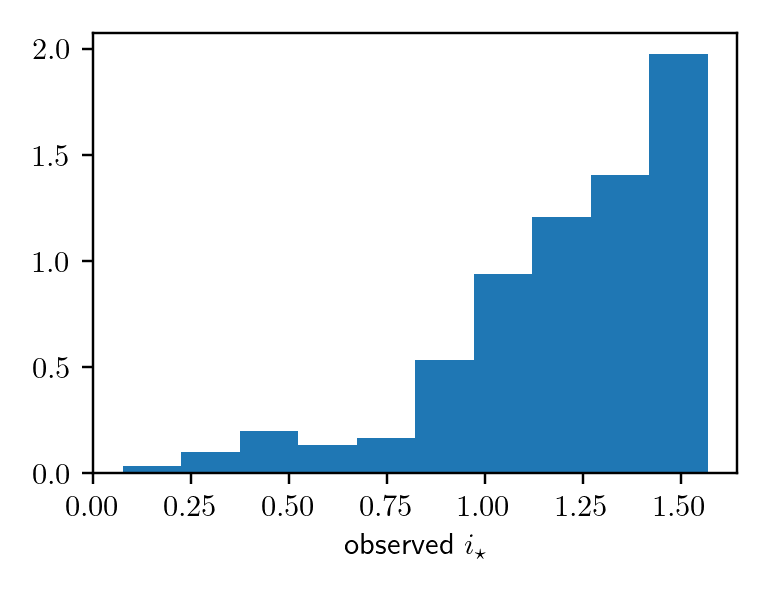

In [7]:
# Add some Gaussian noises
err_istar = 10*np.pi/180
err_lam = 8*np.pi/180

obs_istar = true_istar + err_istar*np.random.normal(size=nsample)
obs_lam = true_lam + err_lam*np.random.normal(size=nsample)

# Limit obs_istar to [0, pi/2]
obs_istar[obs_istar>np.pi/2] = np.pi-obs_istar[obs_istar>np.pi/2]

# Limit obs_lam to [0, pi]
obs_lam[obs_lam<0] = -obs_lam[obs_lam<0]

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_lam, density=True, bins=10)
plt.xlabel(r'observed $\lambda$')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_istar, density=True, bins=10)
plt.xlabel(r'observed $i_\star$')
plt.tight_layout()
plt.show()

If the rotational modulation method is used to infer $i_\star$, we instead measure the rotation period of the star $P_{\rm rot}$, radius of the star $R_\star$, and projected rotation velocity of the star $v\sin{i_\star}$.
We now simulate these observables.

First, we find the *true* values.

Assume the rotation period $P_{\rm rot} \sim {\rm Uniform}(3,20)$ in days and $R_\star \sim \mathcal{N}(1,0.1)$ in $R_\odot$.

<IPython.core.display.Javascript object>


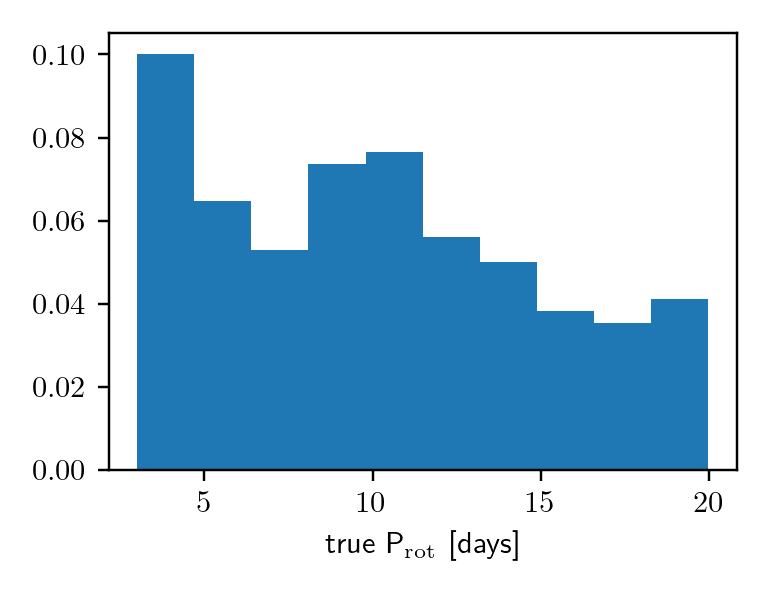

<IPython.core.display.Javascript object>


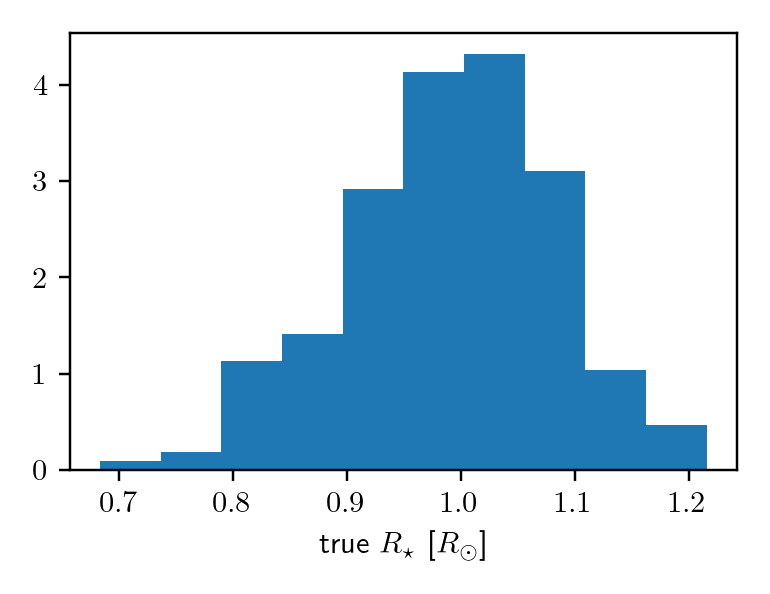

<IPython.core.display.Javascript object>


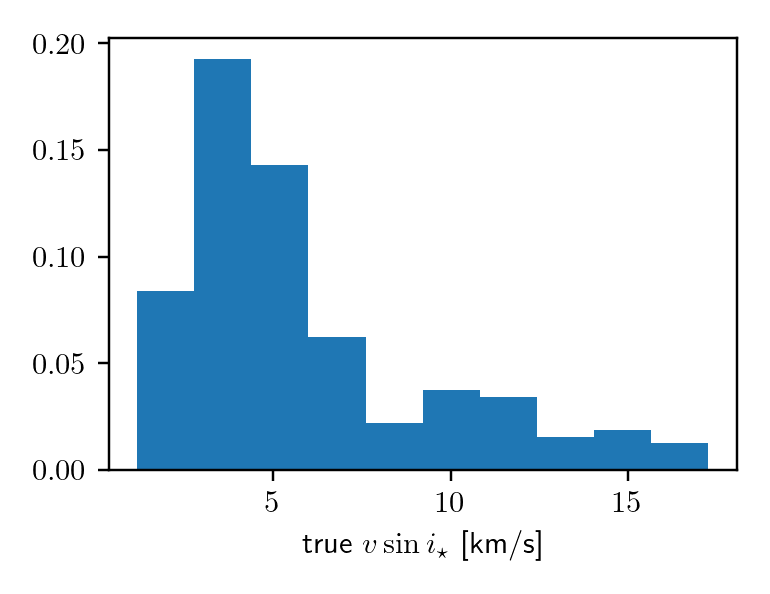

In [8]:
true_Prot = np.random.uniform(3, 20, nsample)
true_Rstar = np.random.normal(1, 0.1, nsample)
true_vrot = 2*np.pi*true_Rstar/true_Prot*8.052 # normalization (1 solar radii)/(1 day) in km/s
true_vsini = true_vrot*np.sin(true_istar)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_Prot, density=True, bins=10)
plt.xlabel(r'true P$_{\rm rot}$ [days]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_Rstar, density=True, bins=10)
plt.xlabel(r'true $R_\star$ [$R_\odot$]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(true_vsini, density=True, bins=10)
plt.xlabel(r'true $v\sin{i_\star}$ [km/s]')
plt.tight_layout()
plt.show()

Now add some Gaussian noise to these values.

<IPython.core.display.Javascript object>


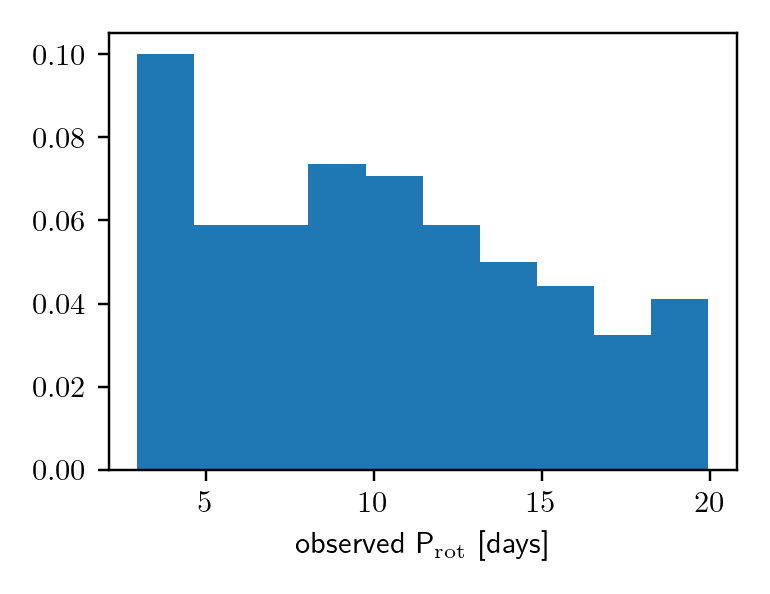

<IPython.core.display.Javascript object>


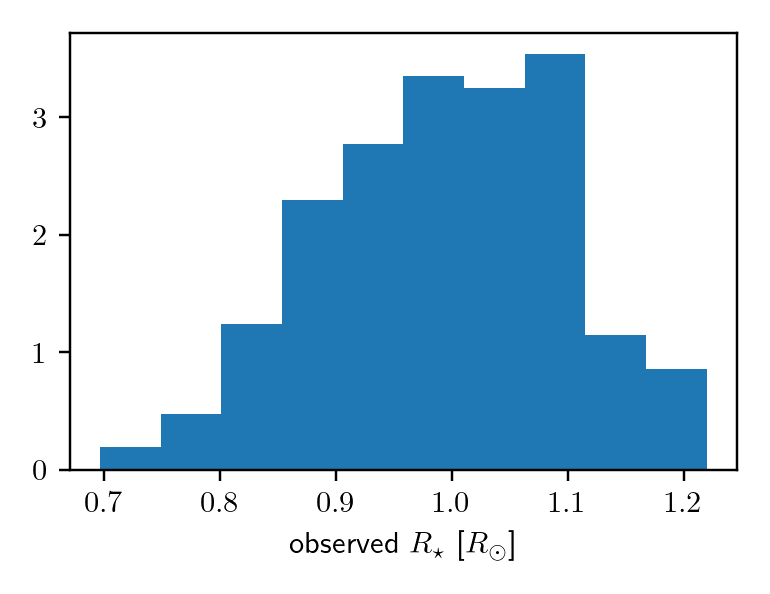

<IPython.core.display.Javascript object>


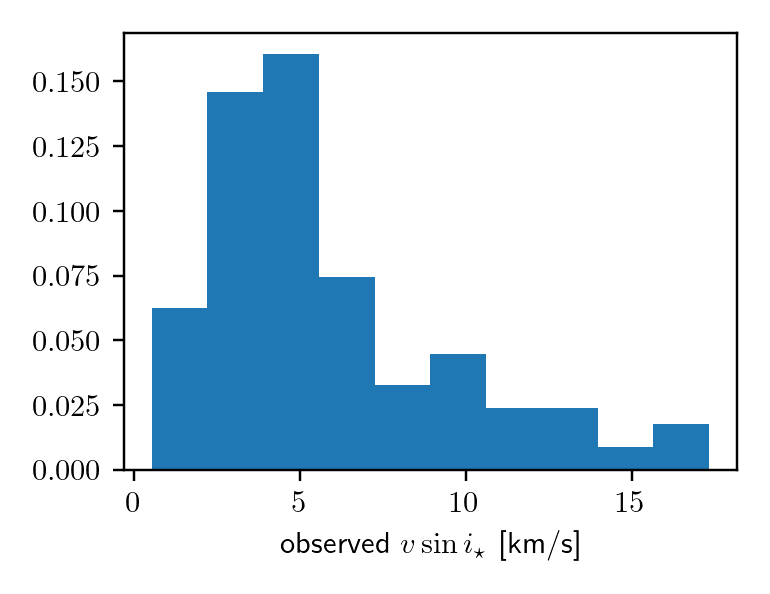

In [9]:
err_Rstar = 0.05
err_Prot = 0.1
err_vsini = 0.5

# Add some Gaussian noises
obs_Rstar =true_Rstar + err_Rstar*np.random.normal(size=nsample)
obs_Prot = true_Prot + err_Prot*np.random.normal(size=nsample)
obs_vsini = true_vsini + err_vsini*np.random.normal(size=nsample)

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_Prot, density=True, bins=10)
plt.xlabel(r'observed P$_{\rm rot}$ [days]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_Rstar, density=True, bins=10)
plt.xlabel(r'observed $R_\star$ [$R_\odot$]')
plt.tight_layout()
plt.show()

plt.figure(figsize=(3.5,2.7),dpi=110)
plt.hist(obs_vsini, density=True, bins=10)
plt.xlabel(r'observed $v\sin{i_\star}$ [km/s]')
plt.tight_layout()
plt.show()

With these simulated data, we are ready for the stellar obliquity inference.

### Case 1: Infer the $\psi$ distribution from $\lambda$

In this model, we infer the stellar obliquity distribution only from sky-projected stellar obliquity measurements obs_lam and err_lam. No stellar inclination measurement is required. 

The stellar obliquity distribution is described as 

$\cos{\psi} \sim 2\times\Bigl( w_0 {\rm Beta}(a_0, b_0) + w_1 {\rm Beta}(a_1, b_1)\Bigr)-1$,

where $w_0, w_1, a_0, b_0, a_1, b_1$ will be inferred. 

Input:
- obs_lam, err_lam

Output:
- Inferred $\psi$ for each planet
- Inferred $\{w, a_0, b_0, a_1, b_1\}$ that describe the stellar obliquity $\psi$ distribution

Note that given our injection, $w_0$ should be close to 0.7 and $w_1$ close to 0.3. The ratio of $a_0/b_0$ should be $\gg1$ and the ratio of $a_1/b_1$ should be close to unity. 

In [10]:
with pm.Model() as model:
    
    # hyperpriors
    w = pm.Dirichlet('w', np.ones(2))

    a0 = pm.Uniform('a0', lower=0, upper=50)
    b0 = pm.Uniform('b0', lower=0, upper=1)
    
    a1 = pm.Uniform('a1', lower=0, upper=10)
    b1 = pm.Uniform('b1', lower=0, upper=10)
    
    components = [pm.Beta.dist(a0,b0), pm.Beta.dist(a1,b1)]
                        
    # uniform priors on cos_istar
    cosi = pm.Uniform('cosi', lower=0., upper=1., shape=nsample)
    sini = pm.Deterministic('sini', at.sqrt(1-cosi**2))
    i = pm.Deterministic('i', at.arccos(cosi))
    
    # uniform priors on λ
    λ = pm.Uniform('λ', lower=0, upper=np.pi, shape=nsample)
    cosλ = pm.Deterministic('cosλ', np.cos(λ))

    # calculate ψ from istar and λ
    cosψ = pm.Deterministic('cosψ', cosλ*sini)
    ψ = pm.Deterministic('ψ', np.arccos(cosψ))
    
    cosθ = pm.Deterministic('cosθ', cosi/at.sin(ψ))
    θ = pm.Deterministic('θ', at.arccos(cosθ))

    # logl for hyper priors
    mix = pm.Potential("mix", pm.logp(pm.Mixture.dist(w=w, comp_dists=components), (cosψ+1)/2))
    
    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)
    
    idata = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a0, b0, a1, b1, cosi, λ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 43 seconds.


Take a look at the summary of the hyperparameters. $\hat{R}$ close to 1 means the convergence of multiple chains.

In [11]:
az.summary(idata, var_names=['w','a0','b0','a1','b1'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w[0]   0.732  0.062   0.616    0.837      0.001    0.001    2867.0    3168.0   
w[1]   0.268  0.062   0.163    0.384      0.001    0.001    2867.0    3168.0   
a0    18.189  3.957  11.195   25.818      0.076    0.053    2732.0    2612.0   
b0     0.931  0.062   0.814    1.000      0.001    0.001    3272.0    2621.0   
a1     1.339  0.543   0.571    2.399      0.012    0.009    1966.0    2297.0   
b1     1.786  1.079   0.441    3.771      0.024    0.018    2138.0    2356.0   

      r_hat  
w[0]    1.0  
w[1]    1.0  
a0      1.0  
b0      1.0  
a1      1.0  
b1      1.0

<IPython.core.display.Javascript object>


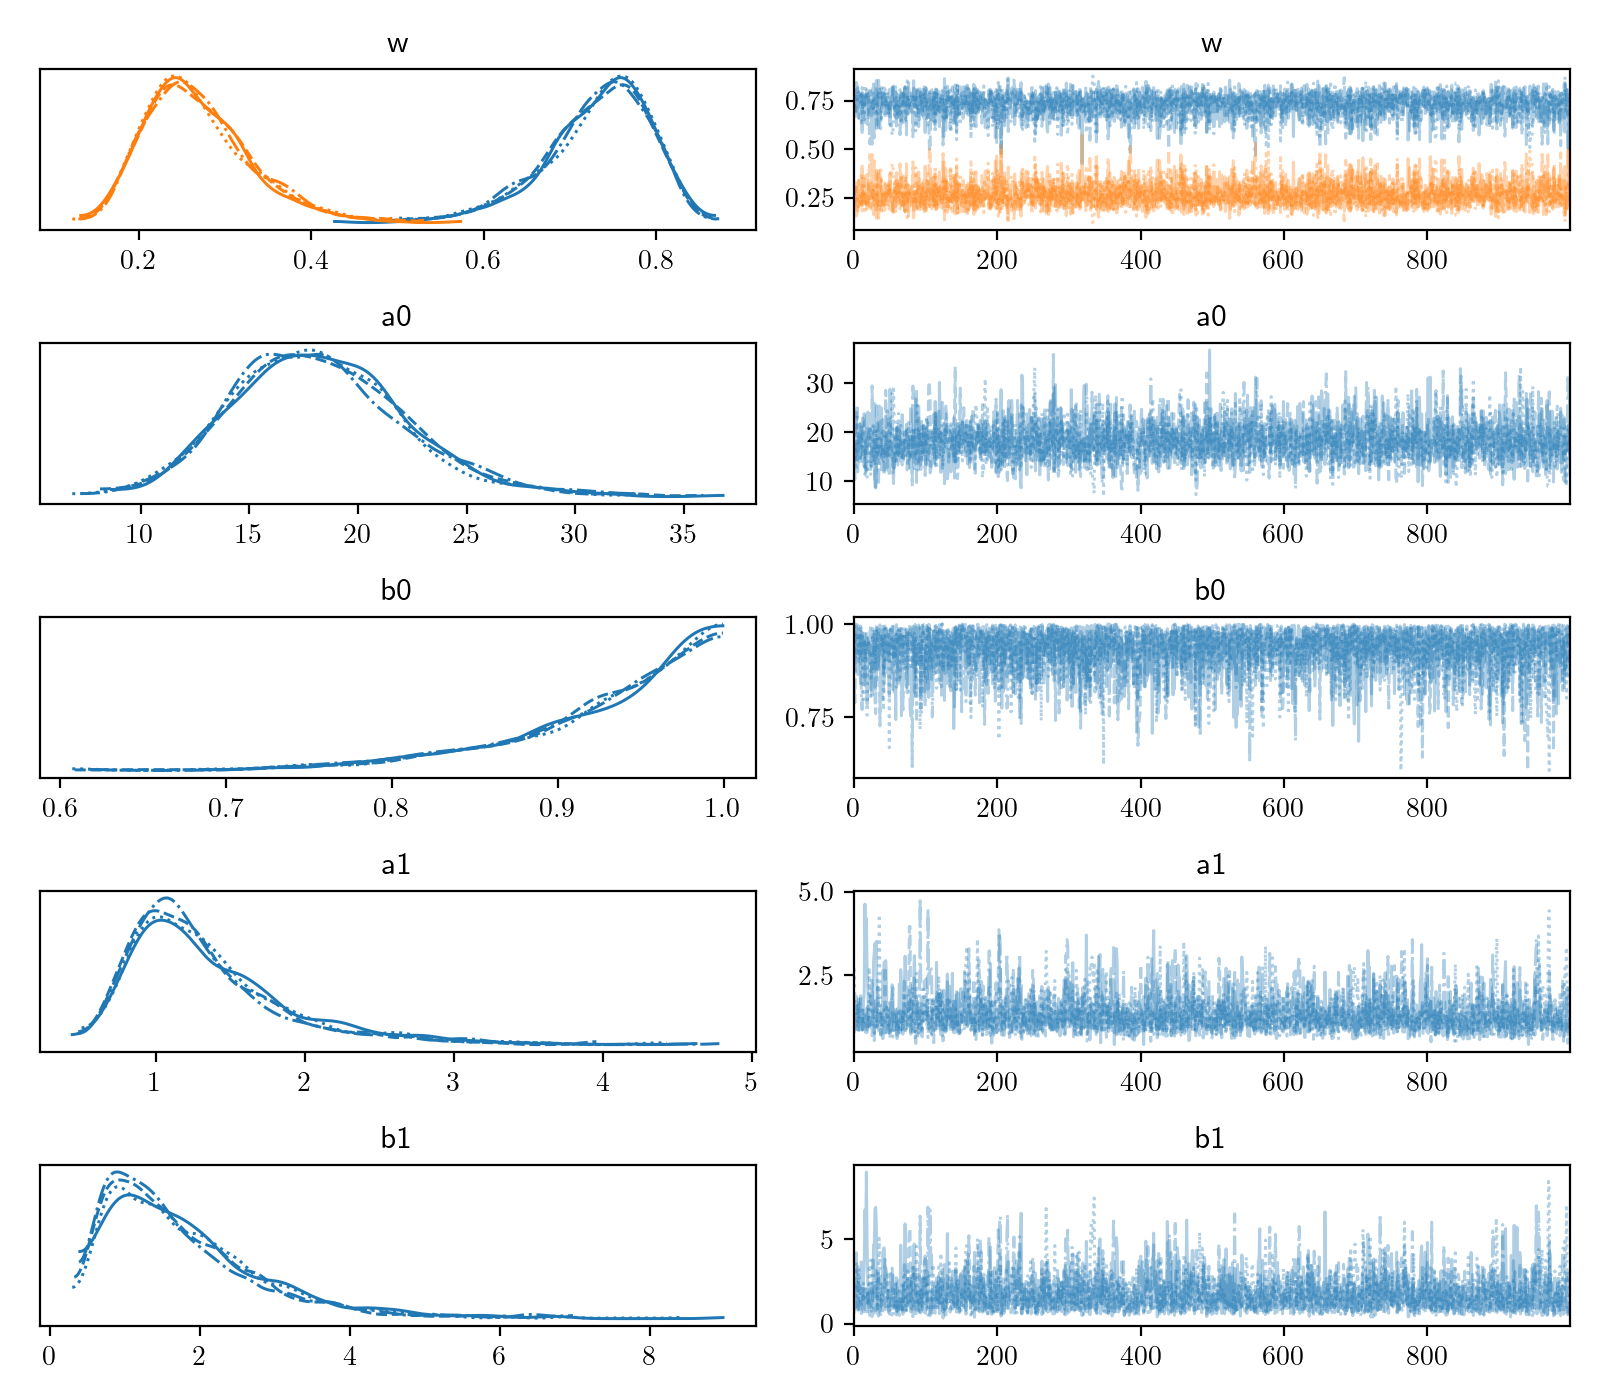

In [12]:
az.plot_trace(idata, var_names=['w','a0','b0','a1','b1'], figsize=(8,7))
plt.tight_layout()

<IPython.core.display.Javascript object>


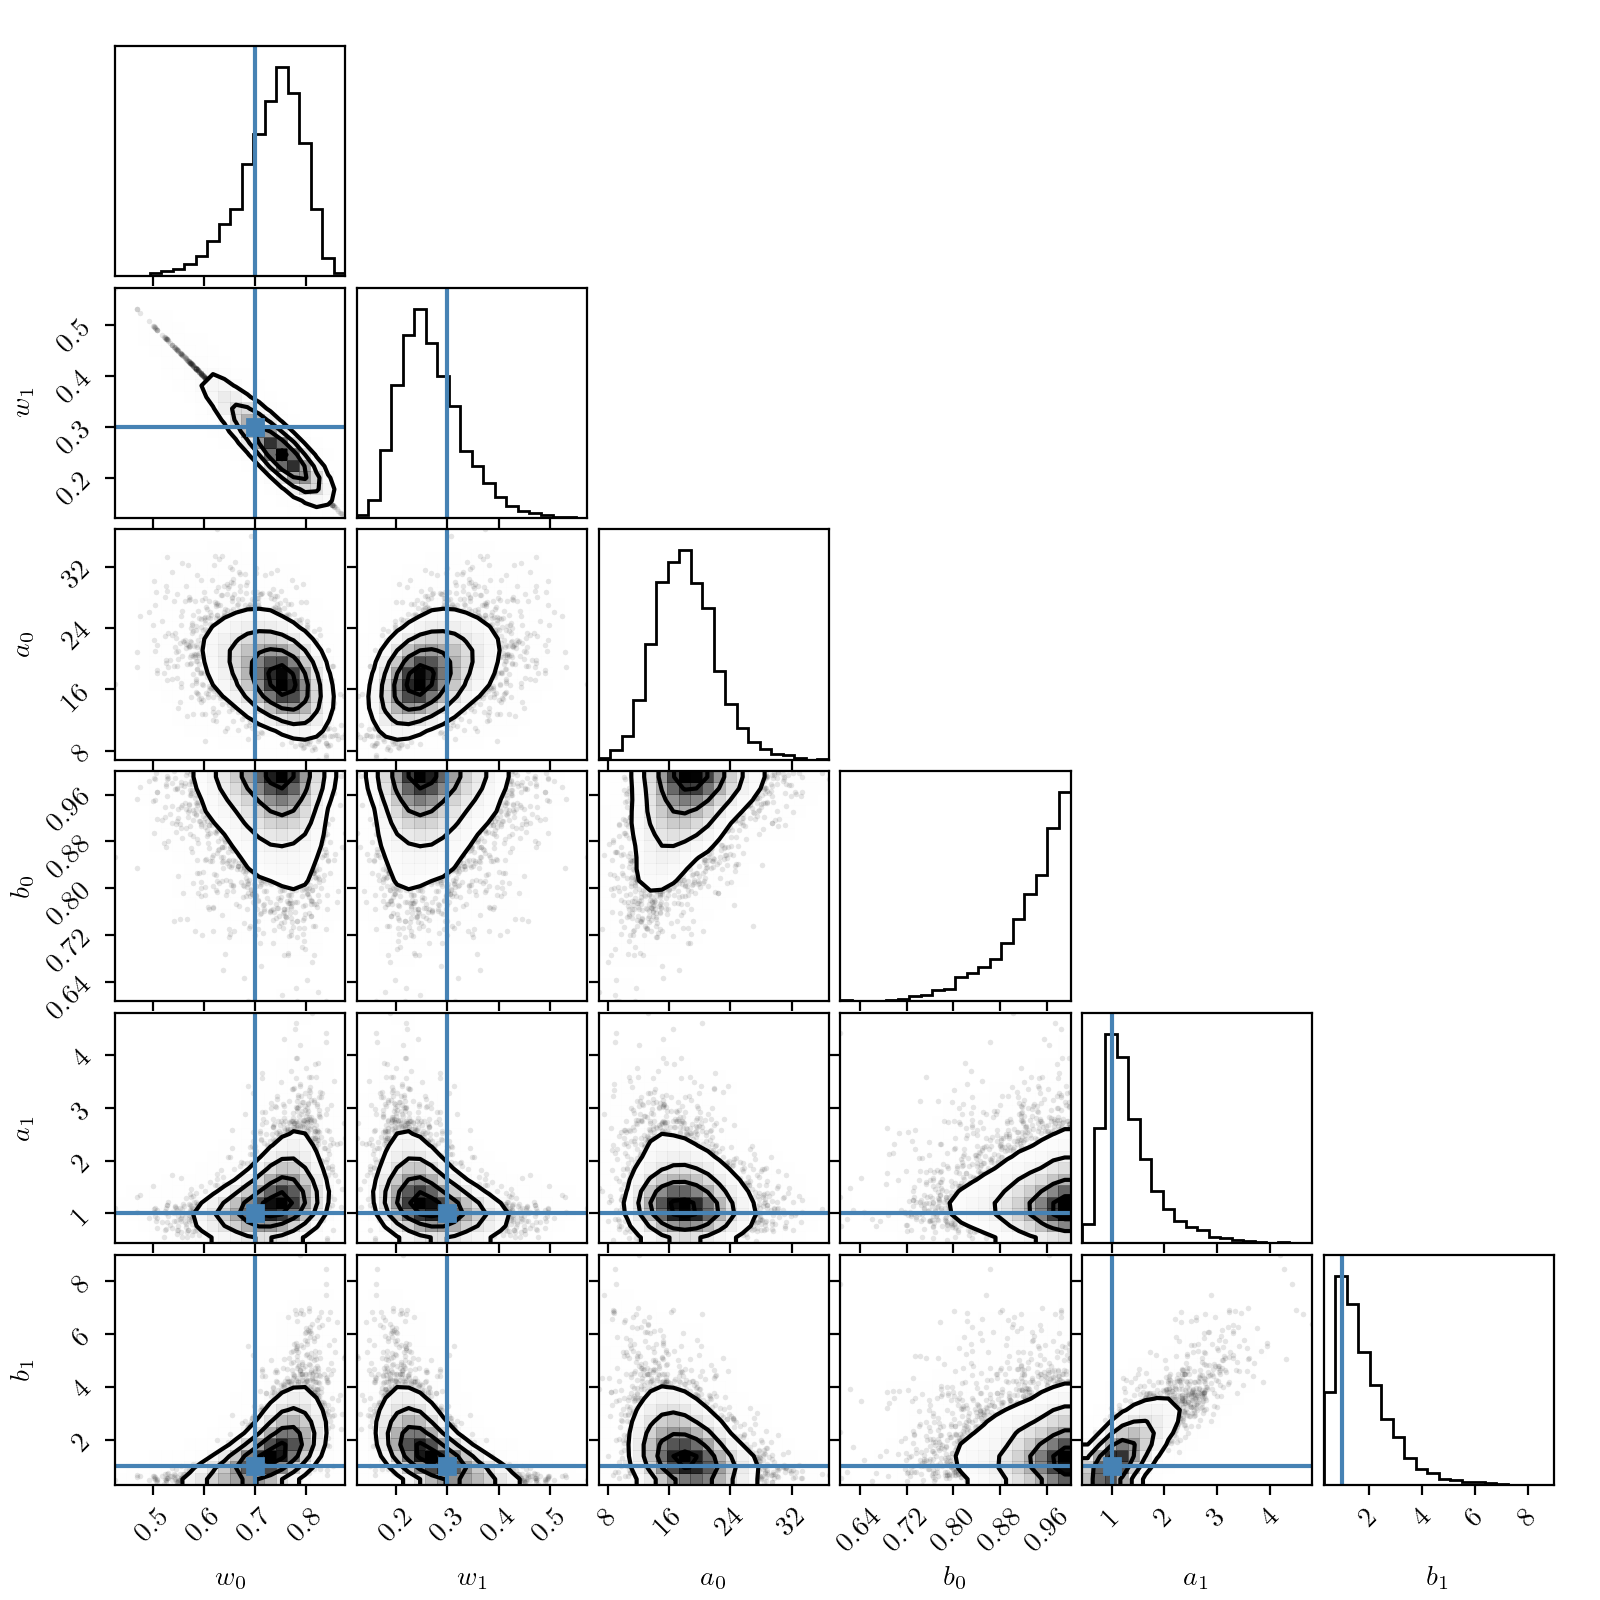

In [13]:
import corner
fig = corner.corner(idata, var_names=['w','a0','b0','a1','b1'], smooth=True, labelpad=0.05,
                    truths={'w': [0.7, 0.3], 'a0':None, 'b0':None, 'a1':1, 'b1':1},
                    labels=[r'$w_0$',r'$w_1$',r'$a_0$',r'$b_0$',r'$a_1$',r'$b_1$']);
fig.set_size_inches(8,8)

We can now plot the $\cos{\psi}$ distribution draws from the posteriors.

In [14]:
from scipy.stats import beta
post = idata.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),4000))
for a in range(4):
    for b in range(1000):
        draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a0[a,b], post.b0[a,b])
                              +post.w[a,b,1].values*beta.pdf(x, post.a1[a,b], post.b1[a,b]))

<IPython.core.display.Javascript object>


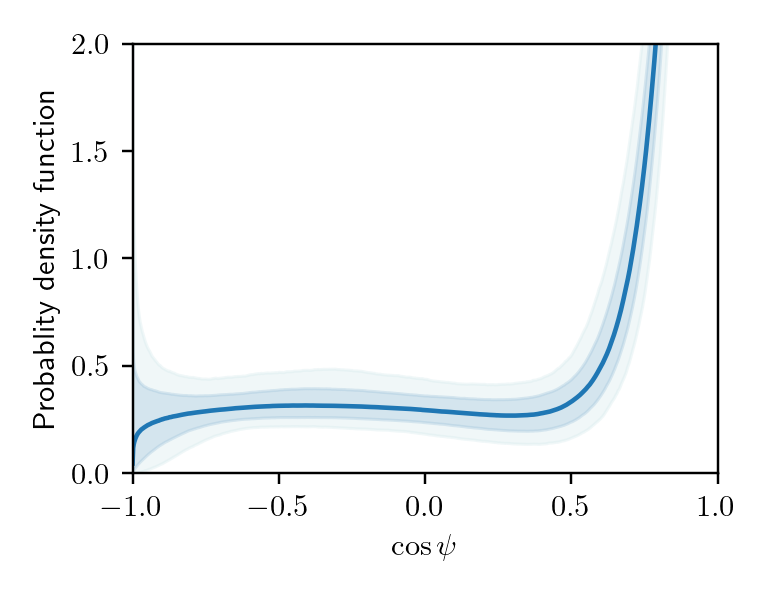

In [15]:
plt.figure(figsize=(3.5,2.7),dpi=110)

q025, q16, q50, q84, q975 = np.percentile(draws, [2.5, 16, 50, 84, 97.5], axis=1)
plt.plot(2*x-1, q50, color='C0')
plt.fill_between(2*x-1, q16, q84, alpha=0.3, label="posterior", color='#7dabd0')
plt.fill_between(2*x-1, q025, q975, alpha=0.3, color='#cfe7ea')

plt.ylim([0,2])
plt.xlim([-1,1])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.tight_layout()
plt.show()

### Case 2: Infer the $\psi$ distribution from $\lambda$ and $i_\star$

In this model, we work on the same data but now add $i_\star$ measurements obs_istar and err_istar.

Input:
- obs_lam, err_lam
- obs_istar, err_istar

Output:
- Inferred $\psi$ for each planet
- Inferred $\{w, a_0, b_0, a_1, b_1\}$ that describe the stellar obliquity $\psi$ distribution

In [16]:
with pm.Model() as model_istar:
    
    # hyperpriors
    w = pm.Dirichlet('w', np.ones(2))

    a0 = pm.Uniform('a0', lower=0, upper=50)
    b0 = pm.Uniform('b0', lower=0, upper=1)
    
    a1 = pm.Uniform('a1', lower=0, upper=10)
    b1 = pm.Uniform('b1', lower=0, upper=10)
    
    components = [pm.Beta.dist(a0,b0), pm.Beta.dist(a1,b1)]
                        
    # uniform priors on cos_istar
    cosi = pm.Uniform('cosi', lower=0., upper=1., shape=nsample)
    sini = pm.Deterministic('sini', at.sqrt(1-cosi**2))
    i = pm.Deterministic('i', at.arccos(cosi))
    
    # uniform priors on λ
    λ = pm.Uniform('λ', lower=0, upper=np.pi, shape=nsample)
    cosλ = pm.Deterministic('cosλ', np.cos(λ))

    # calculate ψ from istar and λ
    cosψ = pm.Deterministic('cosψ', cosλ*sini)
    ψ = pm.Deterministic('ψ', np.arccos(cosψ))
    
    cosθ = pm.Deterministic('cosθ', cosi/at.sin(ψ))
    θ = pm.Deterministic('θ', at.arccos(cosθ))

    # logl for hyper priors
    mix = pm.Potential("mix", pm.logp(pm.Mixture.dist(w=w, comp_dists=components), (cosψ+1)/2))
    
    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)
    
    # logl for istar; observed parameters obs_istar and err_istar
    logl_i = pm.Normal('logl_i', mu=i, sigma=err_istar, observed=obs_istar)
    
    idata_istar = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a0, b0, a1, b1, cosi, λ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


In [17]:
az.summary(idata_istar, var_names=['w','a0','b0','a1','b1'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w[0]   0.616  0.207   0.215    0.812      0.100    0.076       7.0      28.0   
w[1]   0.384  0.207   0.188    0.785      0.100    0.077       7.0      28.0   
a0    14.296  8.210   0.489   23.117      3.905    2.967       7.0      29.0   
b0     0.910  0.116   0.652    1.000      0.040    0.030      12.0      30.0   
a1     3.192  3.637   0.710    9.904      1.805    1.381       7.0      28.0   
b1     1.261  0.612   0.494    2.376      0.148    0.107      14.0    2482.0   

      r_hat  
w[0]   1.53  
w[1]   1.53  
a0     1.53  
b0     1.25  
a1     1.53  
b1     1.20

<IPython.core.display.Javascript object>


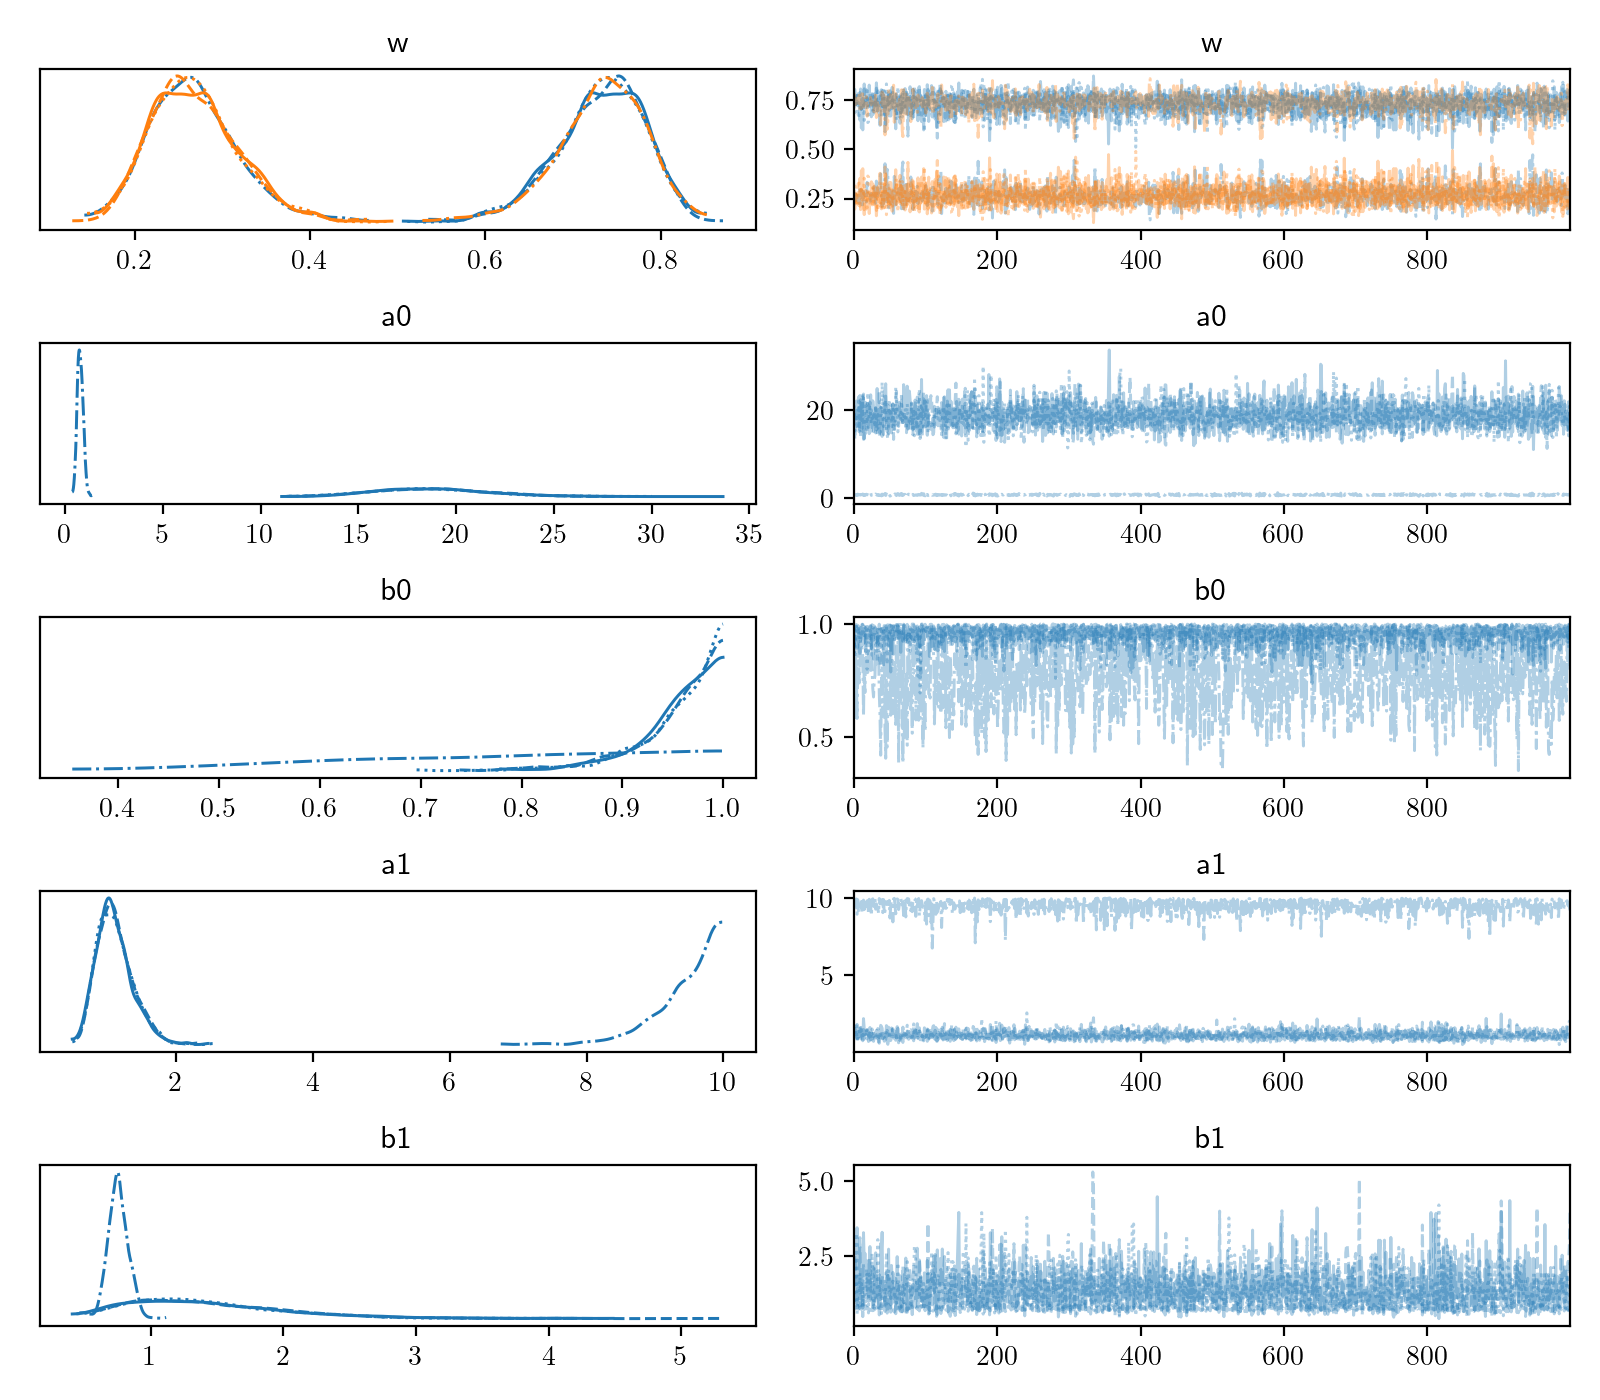

In [18]:
az.plot_trace(idata_istar, var_names=['w','a0','b0','a1','b1'], figsize=(8,7))
plt.tight_layout()

<IPython.core.display.Javascript object>


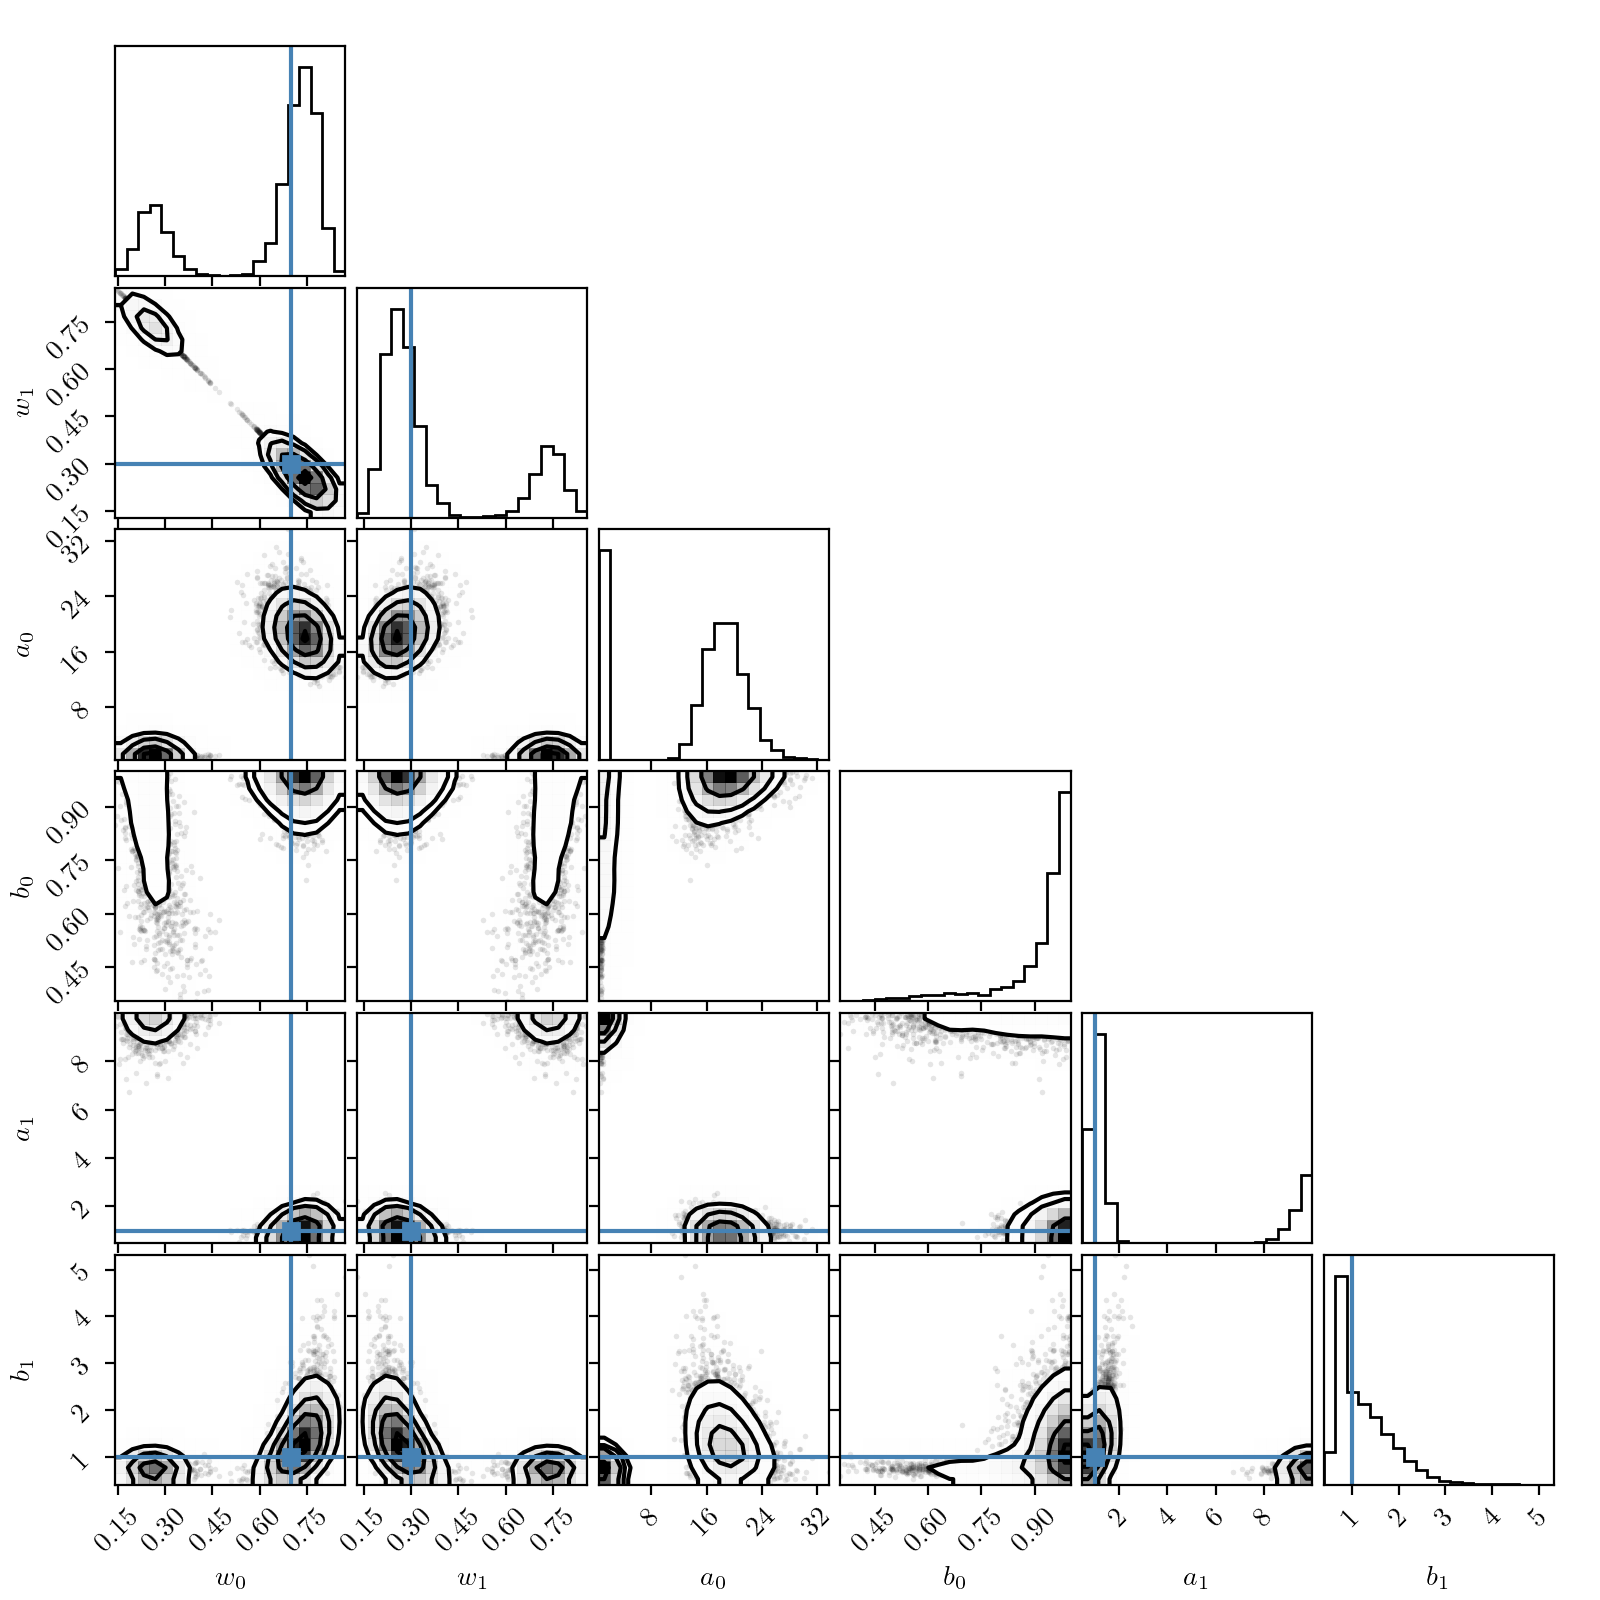

In [19]:
import corner
fig = corner.corner(idata_istar, var_names=['w','a0','b0','a1','b1'], smooth=True, labelpad=0.05,
                    truths={'w': [0.7, 0.3], 'a0':None, 'b0':None, 'a1':1, 'b1':1},
                    labels=[r'$w_0$',r'$w_1$',r'$a_0$',r'$b_0$',r'$a_1$',r'$b_1$']);
fig.set_size_inches(8,8)

In [20]:
from scipy.stats import beta
post = idata_istar.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),4000))
for a in range(4):
    for b in range(1000):
        draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a0[a,b], post.b0[a,b])
                              +post.w[a,b,1].values*beta.pdf(x, post.a1[a,b], post.b1[a,b]))

<IPython.core.display.Javascript object>


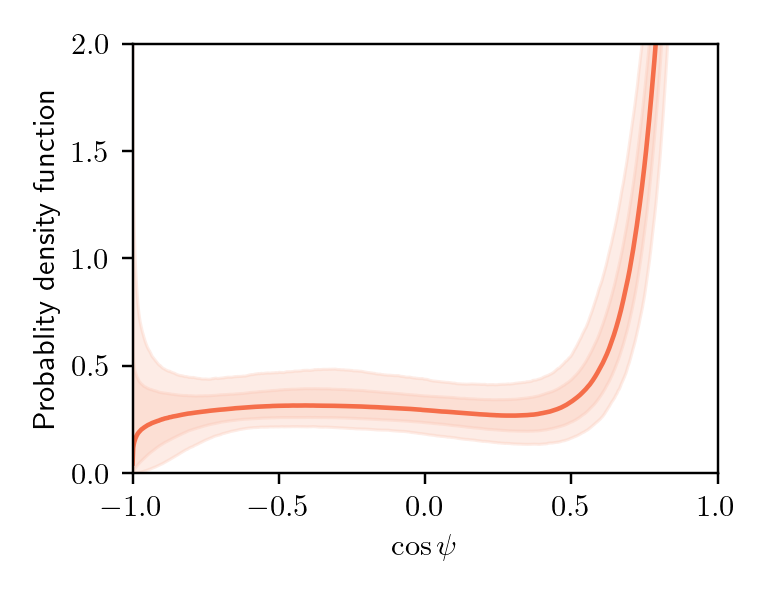

In [21]:
plt.figure(figsize=(3.5,2.7),dpi=110)

plt.plot(2*x-1, q50, color='#f56e4a')
plt.fill_between(2*x-1, q16, q84, alpha=0.3, label="posterior", color='#fbc1ad')
plt.fill_between(2*x-1, q025, q975, alpha=0.3, color='#fbc1ad')
plt.ylim([0,2])
plt.xlim([-1,1])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.tight_layout()
plt.show()

### Case 3: Infer the $\psi$ distribution from $\lambda$, $R_\star$, $P_{\rm rot}$, and $v\sin{i_\star}$

Similar to Case 2, but instead of using obs_istar and err_istar, we infer $i_\star$ from $R_\star$, $P_{\rm rot}$, and $v\sin{i_\star}$ using the rotational modulation method.

Input:
- obs_lam, err_lam
- obs_Rstar, err_Rstar
- obs_Prot, err_Prot
- obs_vsini, err_vsini

Output:
- Inferred $\psi$ for each planet
- Inferred $\{w, a_0, b_0, a_1, b_1\}$ that describe the stellar obliquity $\psi$ distribution

In [22]:
with pm.Model() as model_rot:
    
    # hyperpriors
    w = pm.Dirichlet('w', np.ones(2))

    a0 = pm.Uniform('a0', lower=0, upper=50)
    b0 = pm.Uniform('b0', lower=0, upper=1)
    
    a1 = pm.Uniform('a1', lower=0, upper=10)
    b1 = pm.Uniform('b1', lower=0, upper=10)
    
    components = [pm.Beta.dist(a0,b0), pm.Beta.dist(a1,b1)]
                        
    # uniform priors on cos_istar
    cosi = pm.Uniform('cosi', lower=0., upper=1., shape=nsample)
    sini = pm.Deterministic('sini', at.sqrt(1-cosi**2))
    i = pm.Deterministic('i', at.arccos(cosi))

    # find vsini from Rstar, Prot, and istar
    Rstar = pm.Normal('Rstar', mu=obs_Rstar, sigma=err_Rstar)  # solar radii
    Prot = pm.Normal('Prot', mu=obs_Prot, sigma=err_Prot)  # days
    
    v = pm.Deterministic('v', 2*np.pi*Rstar/Prot*8.052) # normalization (1 solar radii)/(1 day) in km/s
    vsini = pm.Deterministic('vsini', v*sini)

    # uniform priors on λ
    λ = pm.Uniform('λ', lower=0, upper=np.pi, shape=nsample)
    cosλ = pm.Deterministic('cosλ', np.cos(λ))

    # calculate ψ from istar and λ
    cosψ = pm.Deterministic('cosψ', cosλ*sini)
    ψ = pm.Deterministic('ψ', np.arccos(cosψ))
    
    cosθ = pm.Deterministic('cosθ', cosi/at.sin(ψ))
    θ = pm.Deterministic('θ', at.arccos(cosθ))

    # logl for hyper priors
    mix = pm.Potential("mix", pm.logp(pm.Mixture.dist(w=w, comp_dists=components), (cosψ+1)/2))
    
    # logl for λ; observed parameters obs_lam and err_lam
    logl_λ = pm.Normal('logl_λ', mu=λ, sigma=err_lam, observed=obs_lam)
    
    # logl for vsini; observed parameters obs_vsini and err_vsini
    logl_vsini = pm.Normal('logl_vsini', mu=vsini, sigma=err_vsini, observed=obs_vsini)
    
    idata_rot = pm.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [w, a0, b0, a1, b1, cosi, Rstar, Prot, λ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 51 seconds.


In [23]:
az.summary(idata_rot, var_names=['w','a0','b0','a1','b1'])

mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
w[0]   0.712  0.052   0.613    0.804      0.001    0.001    2954.0    2821.0   
w[1]   0.288  0.052   0.196    0.387      0.001    0.001    2954.0    2821.0   
a0    21.642  3.830  14.598   28.808      0.073    0.052    2776.0    2961.0   
b0     0.942  0.053   0.842    1.000      0.001    0.001    3059.0    2240.0   
a1     1.131  0.267   0.686    1.642      0.005    0.004    2642.0    3092.0   
b1     1.319  0.544   0.472    2.318      0.012    0.008    2222.0    2748.0   

      r_hat  
w[0]    1.0  
w[1]    1.0  
a0      1.0  
b0      1.0  
a1      1.0  
b1      1.0

<IPython.core.display.Javascript object>


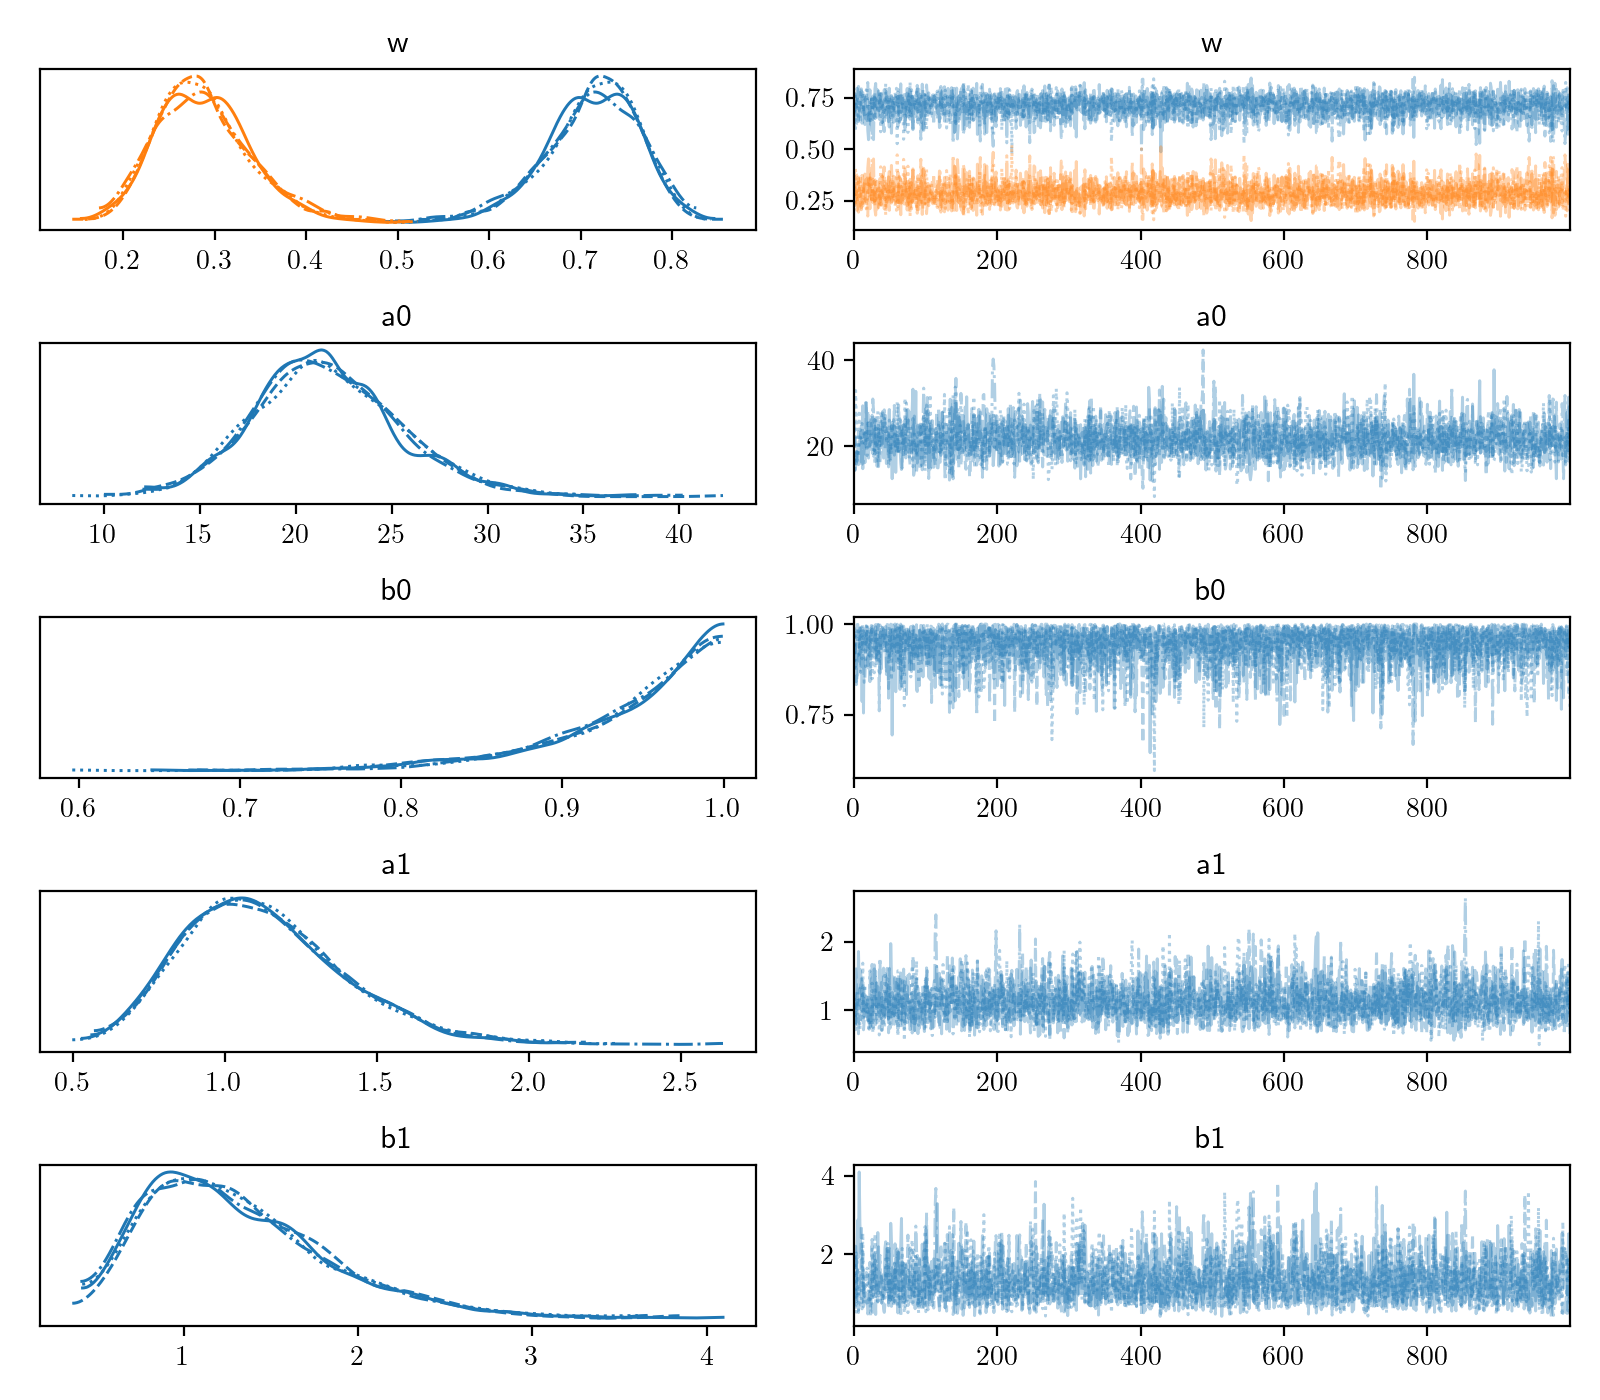

In [24]:
az.plot_trace(idata_rot, var_names=['w','a0','b0','a1','b1'], figsize=(8,7))
plt.tight_layout()

<IPython.core.display.Javascript object>


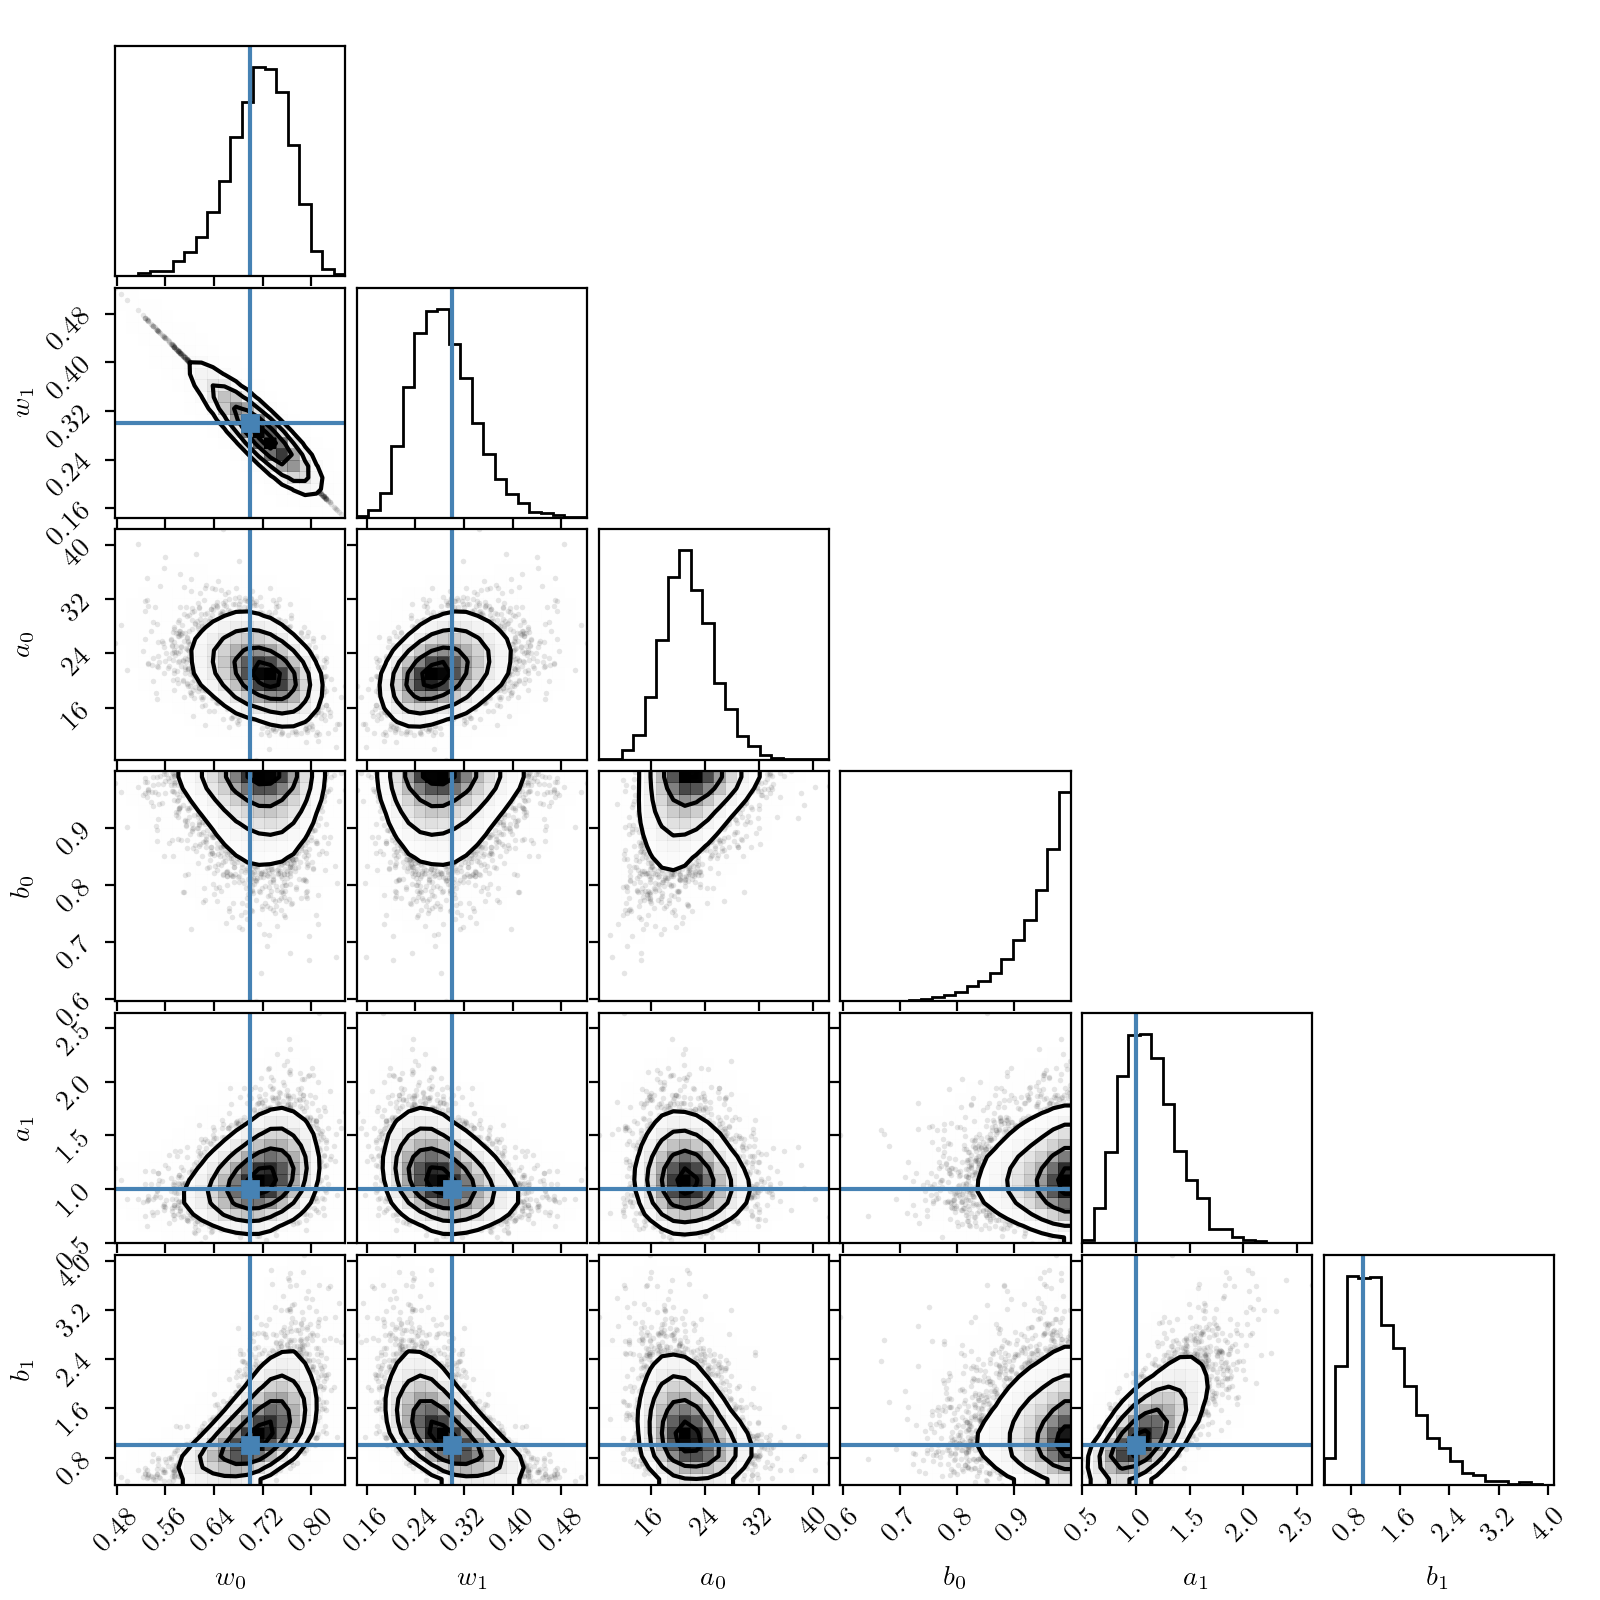

In [25]:
import corner
fig = corner.corner(idata_rot, var_names=['w','a0','b0','a1','b1'], smooth=True, labelpad=0.05,
                    truths={'w': [0.7, 0.3], 'a0':None, 'b0':None, 'a1':1, 'b1':1},
                    labels=[r'$w_0$',r'$w_1$',r'$a_0$',r'$b_0$',r'$a_1$',r'$b_1$']);
fig.set_size_inches(8,8)

In [26]:
from scipy.stats import beta
post = idata_rot.posterior

x = np.linspace(1e-5,1-1e-5,1000)

draws = np.zeros(shape=(len(x),4000))
for a in range(4):
    for b in range(1000):
        draws[:, a*1000+b] = (post.w[a,b,0].values*beta.pdf(x, post.a0[a,b], post.b0[a,b])
                              +post.w[a,b,1].values*beta.pdf(x, post.a1[a,b], post.b1[a,b]))

/var/folders/w7/g_5_gyds171dpgmwdwc233c80000gq/T/ipykernel_55147/1475703076.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(3.5,2.7),dpi=110)


<IPython.core.display.Javascript object>


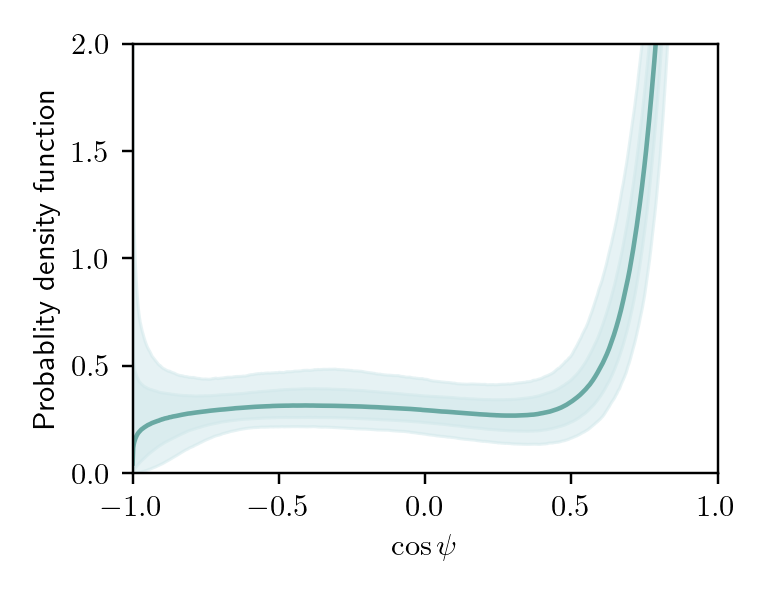

In [27]:
plt.figure(figsize=(3.5,2.7),dpi=110)

plt.plot(2*x-1, q50, color='#69a9a3')
plt.fill_between(2*x-1, q16, q84, alpha=0.5, label="posterior", color='#cfe7ea')
plt.fill_between(2*x-1, q025, q975, alpha=0.5, color='#cfe7ea')
plt.ylim([0,2])
plt.xlim([-1,1])

plt.xlabel(r'$\cos{\psi}$')
plt.ylabel('Probablity density function')

plt.tight_layout()
plt.show()